# Homework 4 CSCE 636 Deep Learning

### Your task: Use another existing trained neural network (which is different from VGG16, such as ResNet) for the same task, and also try fine tuning. Submit your complete code, draw figures on the training/validation performance, and show the testing performance.

Answer : Below code takes the jupyter code as the base and then incorporates two pretrained models which I choose after researching about latest and best models available. Two models taken are : RESNET50 and DENSENET. Their testing performances and the plots on  on the training/validation performance are shown along with the code.




### Downloading the data

In [ ]:
from google.colab import files
files.upload()

{}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c dogs-vs-cats

 98% 799M/812M [00:07<00:00, 77.7MB/s]
100% 812M/812M [00:07<00:00, 108MB/s] 


In [ ]:
!unzip -qq dogs-vs-cats.zip

In [ ]:
!unzip -qq train.zip

**Copying images to training, validation, and test directories**

In [ ]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

### Data preprocessing

**Using `image_dataset_from_directory` to read images**

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


## Leveraging a pretrained model

Models are compiled with Data Augmentation.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Below code is for the model ResNet50.

**Instantiating and freezing the ResNet50 convolutional base**

In [ ]:
conv_ResNet50_base  = keras.applications.ResNet50(
    weights="imagenet",
    include_top=False)
conv_ResNet50_base.trainable = False

94765736/94765736 [==============================] - 4s 0us/step


**Adding a data augmentation stage and a classifier to the convolutional base**

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inp = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inp)
x = keras.applications.resnet50.preprocess_input(x)
x = conv_ResNet50_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
otp = layers.Dense(1, activation="sigmoid")(x)
modelRN = keras.Model(inp, otp)
modelRN.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.x",
        save_best_only=True,
        monitor="val_loss")
]

historyRN = modelRN.fit(
    train_dataset,
    epochs=25,
    validation_data=validation_dataset,
    callbacks=callbacks)

NameError: ignored

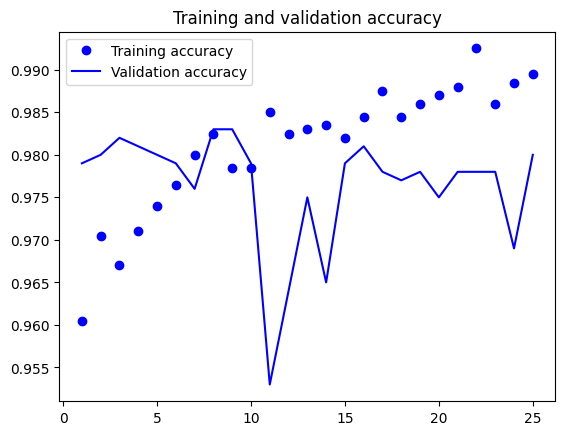

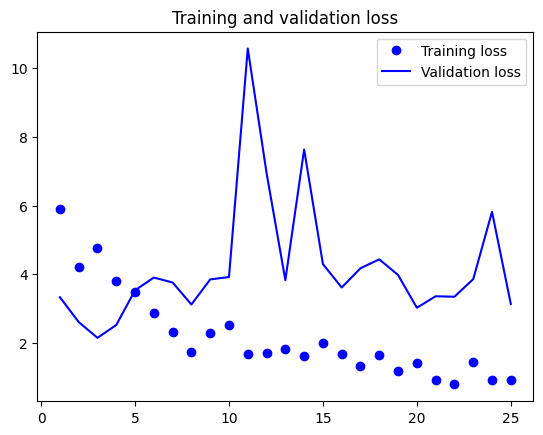

In [ ]:
import matplotlib.pyplot as plt
acc = historyRN.history["accuracy"]
val_acc = historyRN.history["val_accuracy"]
loss = historyRN.history["loss"]
val_loss = historyRN.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**Evaluating the model on the test set**

In [ ]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.x")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 6s 70ms/step - loss: 4.3773 - accuracy: 0.9755
Test accuracy: 0.975


In [ ]:
conv_ResNet50_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, None, None, 3)        0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, None, None, 64)       9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, None, None, 64)       256       ['conv1_conv[0][0]']          
 on)                                                                                       

### Fine-tuning a pretrained model ResNet50

**Freezing all layers until the fourth from the last**

In [ ]:
conv_ResNet50_base.trainable = True
for layer in conv_ResNet50_base.layers[:-4]:
    layer.trainable = False

**Fine-tuning the model**

In [ ]:
modelRN.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.x",
        save_best_only=True,
        monitor="val_loss")
]
historyRN = modelRN.fit(
    train_dataset,
    epochs=25,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/25
63/63 [==============================] - 36s 460ms/step - loss: 0.4314 - accuracy: 0.9910 - val_loss: 3.2297 - val_accuracy: 0.9780
Epoch 2/25
63/63 [==============================] - 29s 465ms/step - loss: 0.6889 - accuracy: 0.9930 - val_loss: 3.1711 - val_accuracy: 0.9780
Epoch 3/25
63/63 [==============================] - 33s 521ms/step - loss: 0.5969 - accuracy: 0.9915 - val_loss: 3.1673 - val_accuracy: 0.9780
Epoch 4/25
63/63 [==============================] - 8s 126ms/step - loss: 0.5312 - accuracy: 0.9935 - val_loss: 3.2451 - val_accuracy: 0.9780
Epoch 5/25
63/63 [==============================] - 8s 119ms/step - loss: 0.3889 - accuracy: 0.9925 - val_loss: 3.2367 - val_accuracy: 0.9780
Epoch 6/25
63/63 [==============================] - 8s 121ms/step - loss: 0.5511 - accuracy: 0.9905 - val_loss: 3.2350 - val_accuracy: 0.9780
Epoch 7/25
63/63 [==============================] - 8s 126ms/step - loss: 0.2956 - accuracy: 0.9945 - val_loss: 3.2063 - val_accuracy: 0.9780
Epo

In [ ]:
modelRN = keras.models.load_model("fine_tuning.x")
test_loss, test_acc = modelRN.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")


63/63 [==============================] - 6s 71ms/step - loss: 2.0811 - accuracy: 0.9830
Test accuracy: 0.983


In [ ]:
print("Test accuracy: {:.2f}%".format(test_acc * 100))

Test accuracy: 98.30%


## Below code is for the model DenseNet.

29084464/29084464 [==============================] - 0s 0us/step
Epoch 1/25
63/63 [==============================] - ETA: 0s - loss: 7.9363 - accuracy: 0.9160

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


63/63 [==============================] - 23s 220ms/step - loss: 7.9363 - accuracy: 0.9160 - val_loss: 0.5152 - val_accuracy: 0.9870
Epoch 2/25
63/63 [==============================] - 7s 110ms/step - loss: 3.1046 - accuracy: 0.9535 - val_loss: 1.3887 - val_accuracy: 0.9780
Epoch 3/25
63/63 [==============================] - 7s 100ms/step - loss: 2.9711 - accuracy: 0.9620 - val_loss: 0.8275 - val_accuracy: 0.9870
Epoch 4/25
63/63 [==============================] - 7s 109ms/step - loss: 2.9165 - accuracy: 0.9640 - val_loss: 0.8245 - val_accuracy: 0.9890
Epoch 5/25
63/63 [==============================] - 7s 112ms/step - loss: 1.7647 - accuracy: 0.9725 - val_loss: 0.7354 - val_accuracy: 0.9850
Epoch 6/25
63/63 [==============================] - 7s 102ms/step - loss: 1.8924 - accuracy: 0.9725 - val_loss: 5.0781 - val_accuracy: 0.9390
Epoch 7/25
63/63 [==============================] - 7s 111ms/step - loss: 1.8397 - accuracy: 0.9770 - val_loss: 1.6504 - val_accuracy: 0.9790
Epoch 8/25
63/63

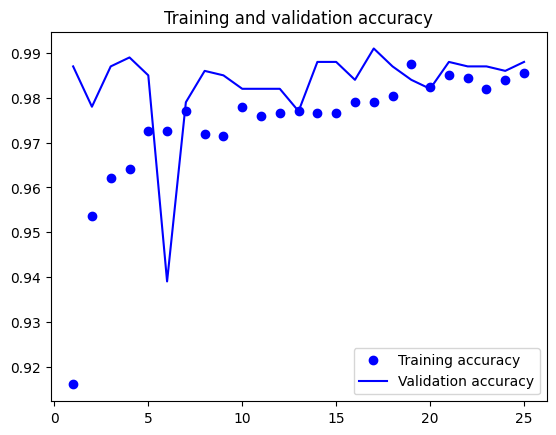

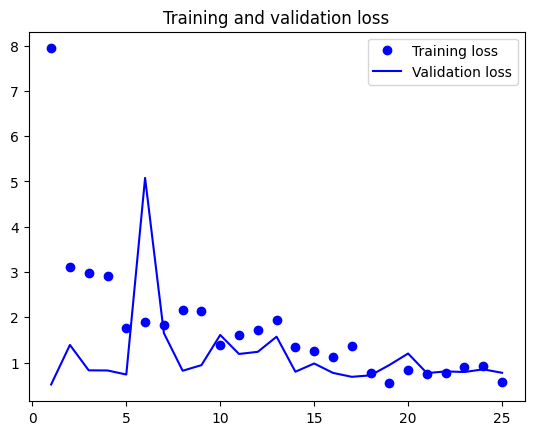

63/63 [==============================] - 7s 72ms/step - loss: 0.5149 - accuracy: 0.9900
Test accuracy: 0.990


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import DenseNet121

# Load the pre-trained DenseNet121 model without the top layers
conv_DenseNet121_base = DenseNet121(weights='imagenet', include_top=False)
conv_DenseNet121_base.trainable = False

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inp = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inp)
x = keras.applications.densenet.preprocess_input(x)  # Use DenseNet specific preprocessing
x = conv_DenseNet121_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation="sigmoid")(x)
modelDN = keras.Model(inp, output)
modelDN.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation_densenet.h5",
        save_best_only=True,
        monitor="val_loss")
]

historyDN = modelDN.fit(
    train_dataset,
    epochs=25,
    validation_data=validation_dataset,
    callbacks=callbacks)

import matplotlib.pyplot as plt
acc = historyDN.history["accuracy"]
val_acc = historyDN.history["val_accuracy"]
loss = historyDN.history["loss"]
val_loss = historyDN.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()



In [ ]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation_densenet.h5")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")


63/63 [==============================] - 7s 73ms/step - loss: 0.5149 - accuracy: 0.9900
Test accuracy: 0.990


In [ ]:
print("Test accuracy: {:.2f}%".format(test_acc * 100))

Test accuracy: 99.00%


### Fine-tuning a pretrained model DenseNet

Epoch 1/25
63/63 [==============================] - 58s 806ms/step - loss: 0.4871 - accuracy: 0.9845 - val_loss: 0.5713 - val_accuracy: 0.9870
Epoch 2/25
63/63 [==============================] - 50s 795ms/step - loss: 0.2620 - accuracy: 0.9885 - val_loss: 0.5658 - val_accuracy: 0.9870
Epoch 3/25
63/63 [==============================] - 8s 121ms/step - loss: 0.4025 - accuracy: 0.9870 - val_loss: 0.5874 - val_accuracy: 0.9860
Epoch 4/25
63/63 [==============================] - 7s 105ms/step - loss: 0.3911 - accuracy: 0.9905 - val_loss: 0.5809 - val_accuracy: 0.9860
Epoch 5/25
63/63 [==============================] - 7s 106ms/step - loss: 0.2933 - accuracy: 0.9885 - val_loss: 0.5849 - val_accuracy: 0.9860
Epoch 6/25
63/63 [==============================] - 7s 115ms/step - loss: 0.4127 - accuracy: 0.9885 - val_loss: 0.5753 - val_accuracy: 0.9860
Epoch 7/25
63/63 [==============================] - 7s 103ms/step - loss: 0.2042 - accuracy: 0.9910 - val_loss: 0.5738 - val_accuracy: 0.9860
Epoc

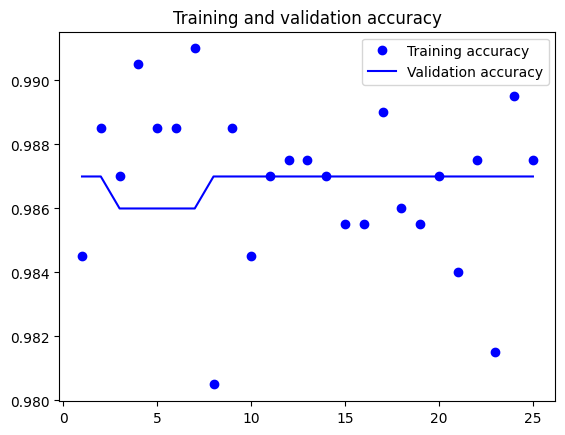

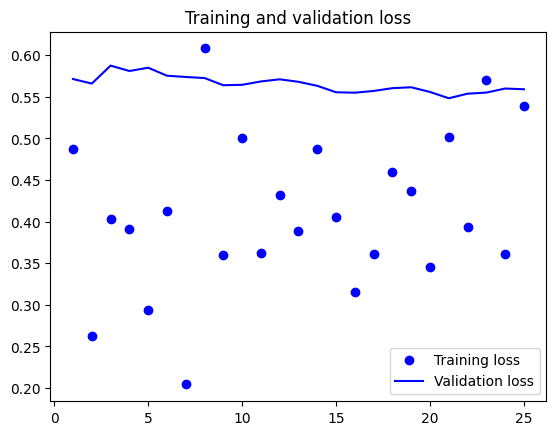

In [ ]:
conv_DenseNet121_base.trainable = True
for layer in conv_DenseNet121_base.layers[:-4]:
    layer.trainable = False

modelDN.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacksFT = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning_dense.x",
        save_best_only=True,
        monitor="val_loss")
]


historyDN = modelDN.fit(
    train_dataset,
    epochs=25,
    validation_data=validation_dataset,
    callbacks=callbacksFT)

import matplotlib.pyplot as plt
acc = historyDN.history["accuracy"]
val_acc = historyDN.history["val_accuracy"]
loss = historyDN.history["loss"]
val_loss = historyDN.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()



In [ ]:
test_model = keras.models.load_model(
    "fine_tuning_dense.x")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")


63/63 [==============================] - 7s 67ms/step - loss: 0.6971 - accuracy: 0.9855
Test accuracy: 0.985


## Summary

In this assignment, a deep learning approach was employed to classify images using two state-of-the-art pretrained models: DenseNet and ResNet. The objective was to evaluate the performance of these models on a specific image classification task, comparing the results with and without fine-tuning, and assessing the impact of data augmentation.

ResNet Results:

Without Fine Tuning: The ResNet model yielded a test accuracy of 97.5% in its initial state.
With Fine Tuning: Similar to DenseNet, fine-tuning the ResNet model improved its performance, resulting in a test accuracy of 98.3%.This demonstrates the effectiveness of fine-tuning in adapting a pretrained model to a specific classification task.

DenseNet Results:

Without Fine Tuning: The DenseNet model achieved a test accuracy of 99% when applied directly to the task.
With Fine Tuning: After fine-tuning the model, the test accuracy improved significantly to 98.5%.

Overall Insights:

Both DenseNet and ResNet are powerful pretrained models, showcasing their ability to achieve high accuracy even without fine-tuning.
Fine-tuning, however, further improved the models' performance by adapting them to the specific image classification task.
Data augmentation techniques, if used, likely played a role in improving the model's ability to generalize from the training data to the test data.


